# Prototype/Model Based Clustering

## K-means

In [1]:
from sklearn import datasets
from sklearn.metrics import adjusted_mutual_info_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from pylab import *
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kemlglearn.cluster import Leader, KMedoidsFlexible
from kemlglearn.datasets import make_blobs
from numpy.random import normal
import numpy as np

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline

iris = datasets.load_iris()

We will play again with the iris dataset, now using K-means. In this case we will look for 3 clusters

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 16.7 µs


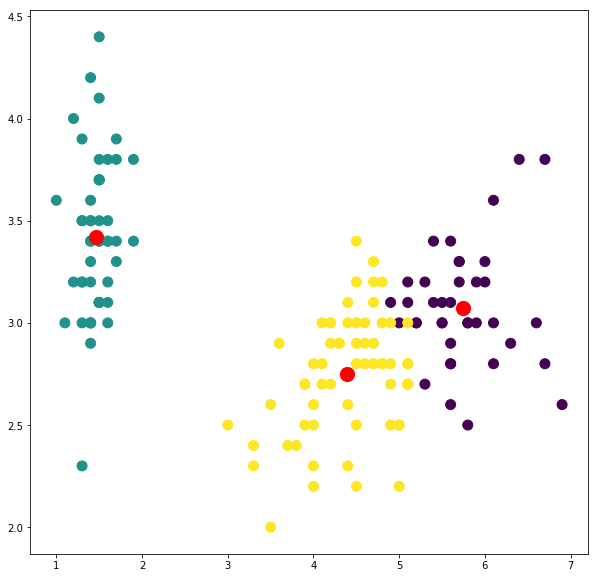

In [2]:
km = KMeans(n_clusters=3)
%time {km.fit(iris['data'])}
labels = km.predict(iris['data'])
plt.figure(figsize=(10,10))
plt.scatter(iris['data'][:, 2], iris['data'][:, 1], c=labels, s=100)
plt.scatter(km.cluster_centers_[:,2], km.cluster_centers_[:,1], c='r', s=200);

Results are a little bit worse than hierarchical clustering

In [3]:
print(adjusted_mutual_info_score(iris['target'], labels))

0.7483723933229484


## K-medoids

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 13.8 µs


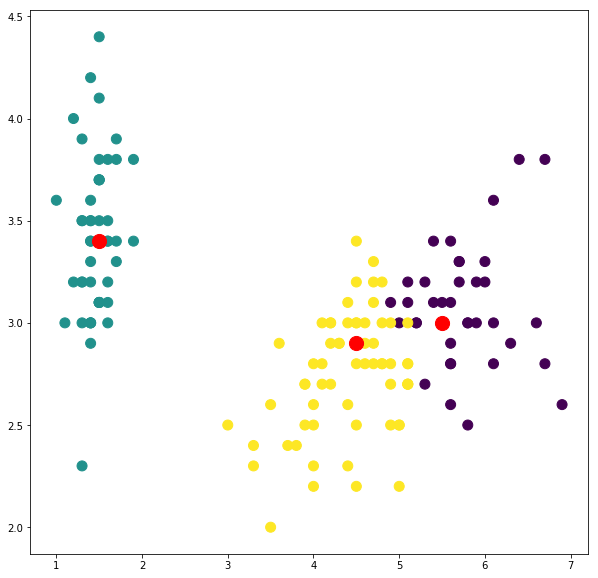

In [4]:
kmd = KMedoidsFlexible(n_clusters=3)
%time {kmd.fit(iris['data'])}
labels = kmd.predict(iris['data'])
plt.figure(figsize=(10,10))
plt.scatter(iris['data'][:, 2], iris['data'][:, 1], c=labels, s=100)
plt.scatter(kmd.cluster_medoids_[:,2], kmd.cluster_medoids_[:,1], c='r', s=200);


In [5]:
print(adjusted_mutual_info_score(iris['target'], labels))

0.7483723933229484


## GMM

Now for Gaussian Mixture Models, first using spherical clusters as estimation method.

CPU times: user 15 µs, sys: 3 µs, total: 18 µs
Wall time: 22.4 µs


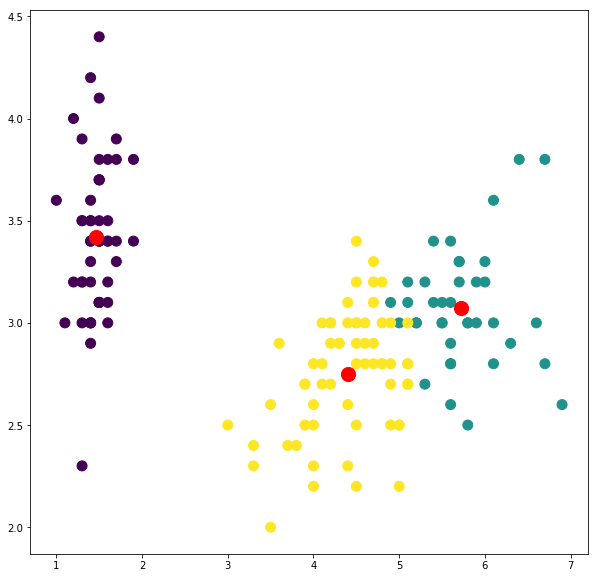

In [6]:
gmm = GaussianMixture(n_components=3, covariance_type='spherical')
%time {gmm.fit(iris['data'])}
labels = gmm.predict(iris['data'])
plt.figure(figsize=(10,10))
plt.scatter(iris['data'][:, 2], iris['data'][:, 1], c=labels, s=100);
plt.scatter(gmm.means_[:,2], gmm.means_[:,1], c='r', s=200);

These are the results of the AMI and the final BIC of the model

In [7]:
print("AMI=", adjusted_mutual_info_score(iris['target'], labels))
print("BIC=", gmm.bic(iris['data']))

AMI= 0.7483723933229484
BIC= 855.0002291894025


As expected the results is comparable to the one from K-means.

Let's change the method of estimation assuming independent attributes (diagonal covariance).

CPU times: user 14 µs, sys: 4 µs, total: 18 µs
Wall time: 22.9 µs


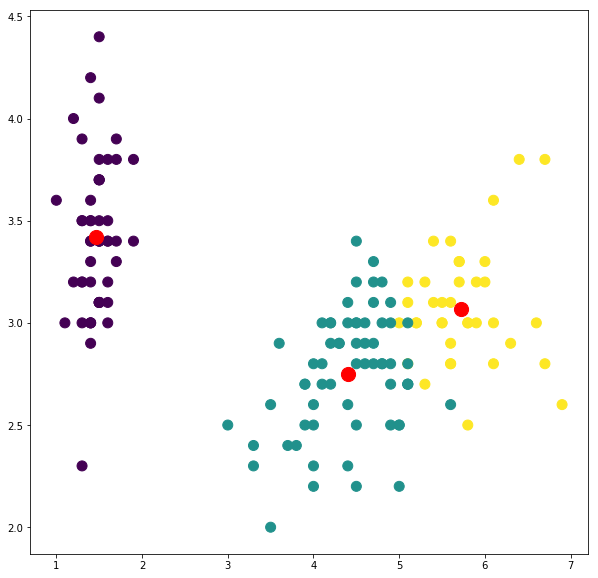

In [8]:
gmm = GaussianMixture(n_components=3, covariance_type='diag')
%time {gmm.fit(iris['data'])}
labels = gmm.predict(iris['data'])
plt.figure(figsize=(10,10))
plt.scatter(iris['data'][:, 2], iris['data'][:, 1], c=labels, s=100)
plt.scatter(gmm.means_[:,2], gmm.means_[:,1], c='r', s=200);

These are the results of the AMI and the final BIC of the model

In [9]:
print("AMI=", adjusted_mutual_info_score(iris['target'], labels))
print("BIC=", gmm.bic(iris['data']))

AMI= 0.7667089075053094
BIC= 746.7839518728003


Now we change to the full model, with dependent attributes

CPU times: user 13 µs, sys: 4 µs, total: 17 µs
Wall time: 22.4 µs


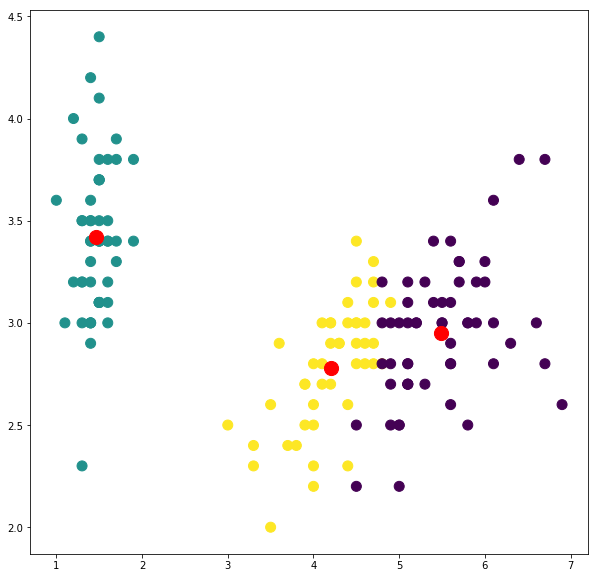

In [10]:
gmm = GaussianMixture(n_components=3, covariance_type='full')
%time {gmm.fit(iris['data'])}
labels = gmm.predict(iris['data'])
plt.figure(figsize=(10,10))
plt.scatter(iris['data'][:, 2], iris['data'][:, 1], c=labels, s=100)
plt.scatter(gmm.means_[:,2], gmm.means_[:,1], c='r', s=200);

These are the results of the AMI and the final BIC of the model

In [11]:
print("AMI=", adjusted_mutual_info_score(iris['target'], labels))
print("BIC=", gmm.bic(iris['data']))

AMI= 0.8970537476260634
BIC= 582.4823873672628


This is now the **best model** we have found

## Leader Algorithm

Now we use the Leader Algorithm (from kemlglearn), the main problem is to guess a radius that results in the number of clusters we want and the quality could not be the best, the upside is that this algorithm is faster than the rest.

In [12]:
@interact(r=(1,5, 0.5))
def g(r=2.5):
    lead = Leader(radius=r)
    %time {lead.fit(iris['data'])}
    labels = lead.predict(iris['data'])
    print("AMI=", adjusted_mutual_info_score(iris['target'], labels))
    plt.figure(figsize=(10,10))
    plt.scatter(iris['data'][:, 2], iris['data'][:, 1], c=labels, s=100)
    plt.scatter(lead.cluster_centers_[:,2], lead.cluster_centers_[:,1], c='r', s=200);

interactive(children=(FloatSlider(value=2.5, description='r', max=5.0, min=1.0, step=0.5), Output()), _dom_classes=('widget-interact',))

# Issues with K-means

Now we will generate artificial data to see some issues of K-means. The first problem appears when the clusters have different sizes and variances. Depending on the ratio of sizes and variance difference, part of the examples from the larger cluster could be assigned to the small one.

In [13]:
@interact(sc1=(25,200, 25), vc1=(0.1, 0.5, 0.1), sc2=(25,200, 25), vc2=(0.1, 0.5,0.1))
def g(sc1=25, vc1=0.1, sc2=200, vc2=0.4):
    global blobs
    global blabels
    blobs, blabels = make_blobs(n_samples=[sc1,sc2], n_features=2, centers=[[1,1], [0,0]], cluster_std=[vc1,vc2])
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    plt.scatter(blobs[:, 0], blobs[:, 1], c=blabels, s=100);

interactive(children=(IntSlider(value=25, description='sc1', max=200, min=25, step=25), FloatSlider(value=0.1, description='vc1', max=0.5, min=0.1), IntSlider(value=200, description='sc2', max=200, min=25, step=25), FloatSlider(value=0.4, description='vc2', max=0.5, min=0.1), Output()), _dom_classes=('widget-interact',))

AMI= 0.4754701889882745


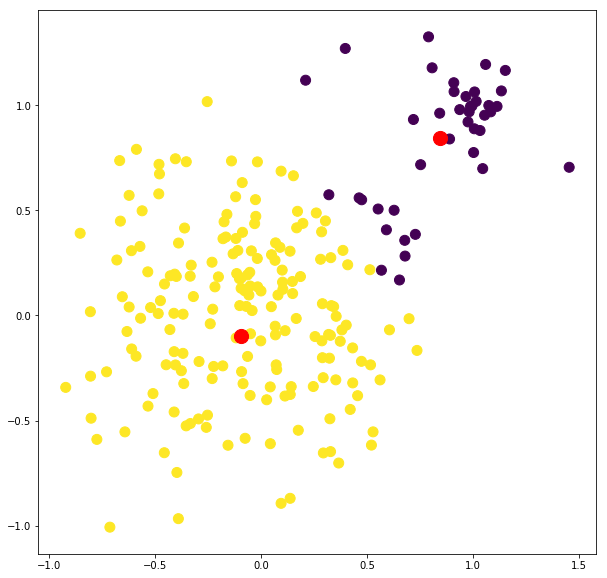

In [14]:
km = KMeans(n_clusters=2)
km.fit(blobs)
labels = km.fit_predict(blobs)
print("AMI=", adjusted_mutual_info_score(blabels, labels))
plt.figure(figsize=(10,10))
plt.scatter(blobs[:, 0], blobs[:, 1], c=labels, s=100)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,0], c='r', s=200);

AMI= 0.23734886101307562


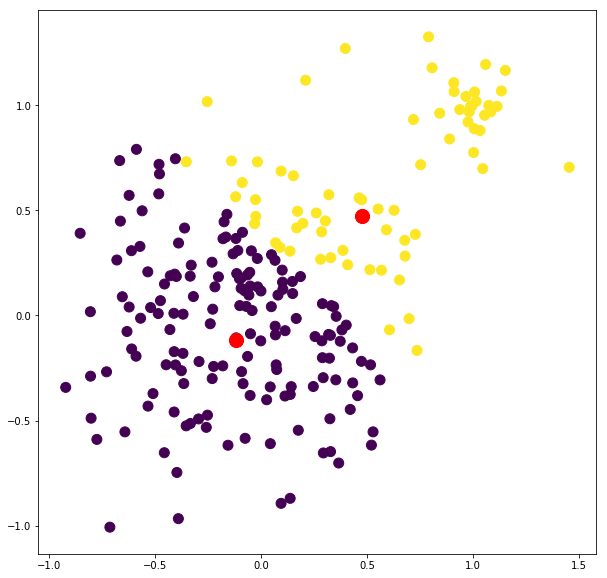

In [15]:
kmd = KMedoidsFlexible(n_clusters=2, max_iter=200)
kmd.fit(blobs)
labels = kmd.fit_predict(blobs)
print("AMI=", adjusted_mutual_info_score(blabels, labels))
plt.figure(figsize=(10,10))
plt.scatter(blobs[:, 0], blobs[:, 1], c=labels, s=100)
plt.scatter(kmd.cluster_medoids_[:,0], kmd.cluster_medoids_[:,0], c='r', s=200);

This could affect less to the GMM algorithm, but it is not free of this problem.

AMI= 0.8145368918537027


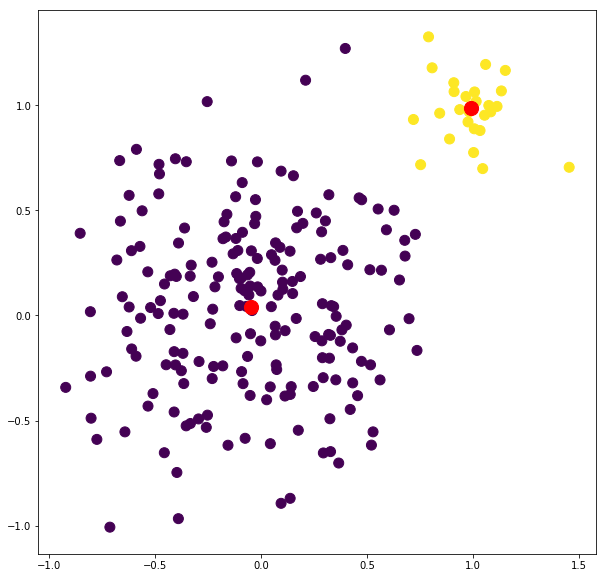

In [16]:
gmm = GaussianMixture(n_components=2, covariance_type='diag')
gmm.fit(blobs)
labels = gmm.predict(blobs)
print("AMI=",adjusted_mutual_info_score(blabels, labels))
plt.figure(figsize=(10,10))
plt.scatter(blobs[:, 0], blobs[:, 1], c=labels, s=100)
plt.scatter(gmm.means_[:,0], gmm.means_[:,1], c='r', s=200);

Problems also appear when the clusters are not spherical and some attributes have more variance than others (actually are elipsoids). If the clusters are not well separated, the partition can result in not very natural clusters. You can change this data set and see what happens if you change the size, separation and variance of the clusters.

In [17]:
@interact(sc1=(25,200, 25), v1=(0.1, 0.2, 0.1), sc2=(25,200, 25), v2=(0.6, 1,0.1))
def g(sc1=75, v1=0.1, sc2=75, v2=0.9):
    global data, dlabels
    data = np.zeros((sc1+sc2,2))
    data[0:sc1, 0] = normal(loc=-0.5, scale=v1, size=sc1)
    data[0:sc1, 1] = normal(loc=0.0, scale=v2, size=sc1)
    data[sc1:, 0] = normal(loc=0.5, scale=v1, size=sc2)
    data[sc1:, 1] = normal(loc=0.0, scale=v2, size=sc2)
    dlabels = np.zeros(sc1+sc2)
    dlabels[sc1:] = 1
    plt.figure(figsize=(10,10))
    plt.ylim(-2,2)
    plt.xlim(-2,2)
    plt.scatter(data[:, 0], data[:, 1], c=dlabels, s=100);

interactive(children=(IntSlider(value=75, description='sc1', max=200, min=25, step=25), FloatSlider(value=0.1, description='v1', max=0.2, min=0.1), IntSlider(value=75, description='sc2', max=200, min=25, step=25), FloatSlider(value=0.9, description='v2', max=1.0, min=0.6), Output()), _dom_classes=('widget-interact',))

K-means divides the two clusters wrong (sometimes depends on the initialization, you can use the random_state parameter of K-means to see if different initializations get it right)

AMI= -0.004883466987082794


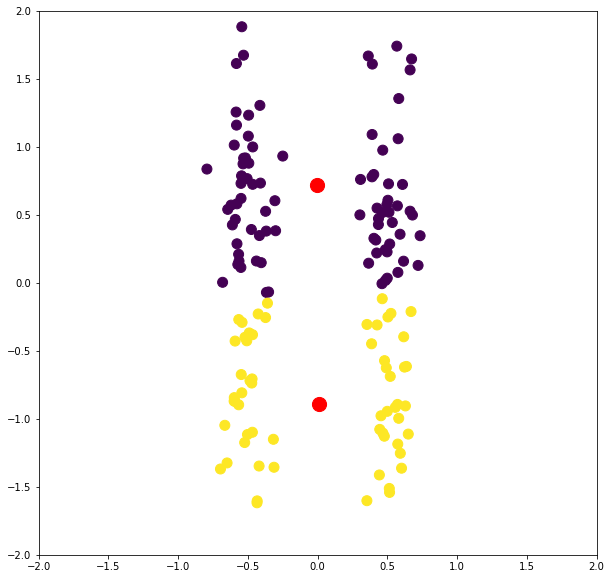

In [18]:
km = KMeans(n_clusters=2)
labels = km.fit_predict(data)
print("AMI=", adjusted_mutual_info_score(dlabels, labels))
plt.figure(figsize=(10,10))
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.scatter(data[:, 0], data[:, 1], c=labels, s=100)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], c='r', s=200);

AMI= 1.0


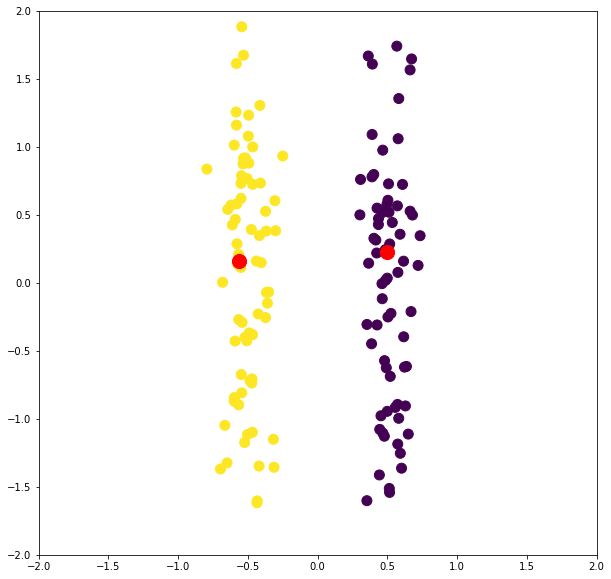

In [19]:
kmd = KMedoidsFlexible(n_clusters=2)
labels = kmd.fit_predict(data)
print("AMI=", adjusted_mutual_info_score(dlabels, labels))
plt.figure(figsize=(10,10))
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.scatter(data[:, 0], data[:, 1], c=labels, s=100)
plt.scatter(kmd.cluster_medoids_[:,0], kmd.cluster_medoids_[:,1], c='r', s=200);

AMI= -0.004884193574792436


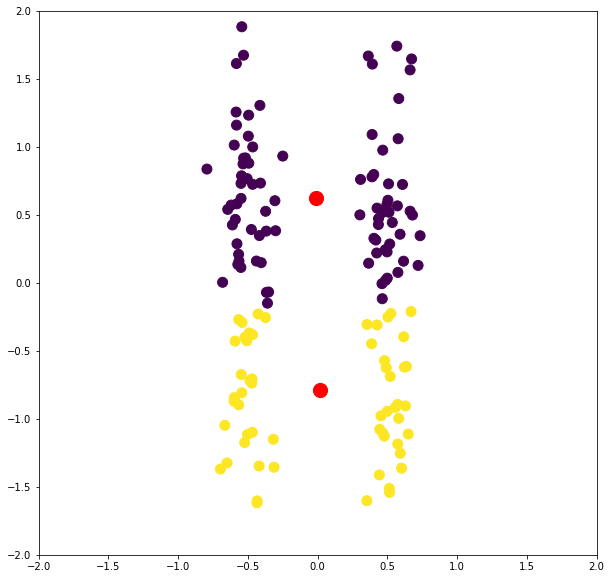

In [20]:
gmm = GaussianMixture(n_components=2, covariance_type='diag')
gmm.fit(data)
labels = gmm.predict(data)
print("AMI=",adjusted_mutual_info_score(dlabels, labels))
plt.figure(figsize=(10,10))
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.scatter(data[:, 0], data[:, 1], c=labels, s=100)
plt.scatter(gmm.means_[:,0], gmm.means_[:,1], c='r', s=200);

If you play with the characteristics of the dataset, you will see that usually if data are separated enough or the variances are different enough, clusters that have similar number of examples are partitioned right most of the time.